In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import community as community_louvain

import plotly.graph_objects as go

In [24]:
def is_symmetric(A, tol=1e-8):
    return np.linalg.norm(A-A.T, np.Inf) < tol

In [25]:
stata_household = pd.read_stata('banerjee_data/datav4.0/Data/2. Demographics and Outcomes/household_characteristics.dta')

# Preprocess

(array([7095., 7809.]),
 array([ 0,  2, 10]),
 <BarContainer object of 2 artists>)

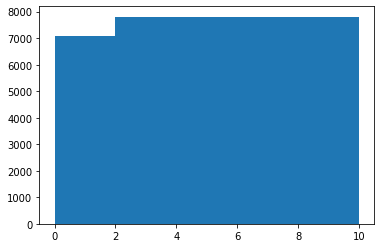

In [26]:
plt.hist(stata_household['room_no']/(np.sqrt(stata_household['bed_no']+1)), bins = [0,2,10])

In [27]:
#choose which vill
vill_no = 1

stata_vill = stata_household.where(stata_household['village'] == vill_no).dropna(how = 'all')

room_type = np.array(stata_vill['room_no']/np.sqrt((stata_vill['bed_no']+1))<=2)

In [28]:
# which adjacency matrices to union?
#files = ['borrowmoney', 'giveadvice', 'helpdecision','keroricecome','keroricego','lendmoney','medic','templecompany','visitcome','visitgo']

money_hyp_files = ['borrowmoney', 'lendmoney', 'keroricecome', 'keroricego']
trust_hyp_files = ['helpdecision', 'giveadvice', 'medic']
trust_fact_files = ['visitcome','visitgo', 'templecompany']

files = trust_hyp_files

old_file = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + files[0] +'_HH_vilno_' + str(vill_no) + '.csv'
ad_mat_old= (pd.read_csv(old_file, header=None)).to_numpy()

# union all the desired files together

for file in files[1:]:
    new_file = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + file +'_HH_vilno_' + str(vill_no) + '.csv'
    ad_mat_new = (pd.read_csv(new_file, header=None)).to_numpy()
    
    ad_mat_old = np.bitwise_or(ad_mat_old, ad_mat_new)
    

ad_mat_np = ad_mat_old

In [29]:
matrix_key_filename = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrix Keys/key_HH_vilno_' + str(vill_no) + '.csv'
ad_mat_key_vill = np.array(pd.read_csv(matrix_key_filename, header = None))

# confirm households in every village are actually labelled 1...h
assert(np.array_equal(ad_mat_key_vill.flatten(),stata_vill['HHnum_in_village'].values))

In [30]:
# confirm is symmetric
assert(is_symmetric(ad_mat_np))

# Visualize

In [31]:
def make_edge(x, y):
    return  go.Scatter(x         = x,
                       y         = y,
                       mode = 'lines',
                       line = dict(width = 1, color = 'gray'))

def graph_vis(G_nx, types, partition, info):
    pos = nx.spring_layout(G_nx)
    edge_trace = []
    k = 0
    for edge in G_nx.edges():

        char_1 = edge[0]
        char_2 = edge[1]

        x0, y0 = pos[char_1]
        x1, y1 = pos[char_2]

        trace  = make_edge([x0, x1, None], [y0, y1, None])
        k = k + 1

        edge_trace.append(trace)

    node_trace = go.Scatter(x         = [],
                            y         = [],
                            textposition = "top center",
                            textfont_size = 10,
                            hoverinfo = 'text',
                            hovertext = [],
                            text      = [],
                            mode      = 'markers+text',
                            marker    = dict(color = list(partition.values()),
                                             size  = 7,
                                             symbol = list(types)
                                             ))

    for node in G_nx.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    
    node_trace['text'] = info


    layout = go.Layout(xaxis = {'showgrid': False, 'zeroline': False},
                        yaxis = {'showgrid': False, 'zeroline': False},
                        autosize = False,
                        width = 1000,
                        height = 1000)

    # Create figure
    fig = go.Figure(layout = layout)
    for trace in edge_trace:
        fig.add_trace(trace)
    fig.add_trace(node_trace)
    fig.update_layout(showlegend = False)
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)
    fig.show()

average degree: 3.340659340659341
num communities: 54


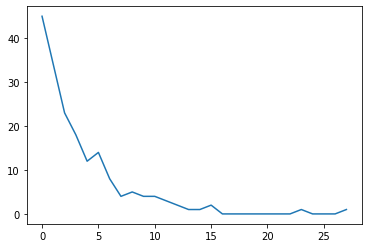

In [33]:
G_nx = nx.from_numpy_matrix(ad_mat_np)

G_deg = nx.degree_histogram(G_nx)
plt.plot(G_deg)
G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
print('average degree: {}'.format(sum(G_deg_sum) / G_nx.number_of_nodes()))

partition = {}
partition = community_louvain.best_partition(G_nx)

num_comm = max(partition.values())
print('num communities: {}'.format(num_comm))

types = room_type
info = stata_vill['HHnum_in_village'].values
graph_vis(G_nx, types, partition, info)

# Fitting Model

## Metrics we care about

triangle count/clustering coefficient 

attribute assortativity

In [34]:
import sim_lib.util as util
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
from math import isclose
from scipy.stats import wasserstein_distance
from itertools import combinations

In [35]:
type_dict = {k: v for k, v in enumerate(types)}
nx.set_node_attributes(G_nx, type_dict, "type")

In [36]:
data_tri_cnt = sum((nx.triangles(G_nx)).values())/3
data_assort = nx.attribute_assortativity_coefficient(G_nx, "type")
data_max_clique = max((nx.node_clique_number(G_nx)).values())

In [37]:
print(data_tri_cnt, data_assort)

print(sum(types)/len(types))

105.0 0.17877006197362152
0.7912087912087912


In [38]:
_N = G_nx.number_of_nodes()
ctxt_likelihood = sum(types)/len(types)

In [39]:
def count_stable_triads(G):
    num_stable_triad = 0
    num_em_ho_st = 0
    num_sc_ho_st = 0
    num_sc_he_st = 0
    for triad in combinations(G.vertices, 3):
        attr_funcs = [ t.data['attr'] for t in triad ]
        if len(set(attr_funcs)) != 1:
            continue
            
        struct_funcs = [ t.data['struct'] for t in triad ]
        if len(set(struct_funcs)) != 1:
            continue
          
        if triad[0].data['struct'] == 'em' and triad[0].data['attr'] == 'ho':
            
            # Homophily so all same type
            if len(set([ t.data['type_name'] for t in triad ])) != 1:
                continue
                
            # Triangle
            if G.are_neighbors(triad[0], triad[1]) and G.are_neighbors(triad[0], triad[2]) \
                    and G.are_neighbors(triad[1], triad[2]):
                num_em_ho_st += 1
        elif triad[0].data['struct'] == 'sc' and triad[0].data['attr'] == 'ho':
            
            # Homophily all same type
            if len(set([ t.data['type_name'] for t in triad ])) != 1:
                continue
                
            # Exactly two edges
            if sum([ G.are_neighbors(p[0], p[1]) for p in combinations(triad, 2) ]) == 2:
                num_sc_ho_st += 1
        elif triad[0].data['struct'] == 'sc' and triad[0].data['attr'] == 'he':
            
            # Heterophily so not all same type
            if len(set([ t.data['type_name'] for t in triad ])) == 1:
                continue
                
            # Exactly two edges
            edge_pairs = []
            for pair in combinations(triad, 2):
                if G.are_neighbors(pair[0], pair[1]):
                    edge_pairs.append(pair)
            
            if len(edge_pairs) != 2:
                continue
            if edge_pairs[0][0].data['type_name'] != edge_pairs[0][1].data['type_name'] and \
                    edge_pairs[1][0].data['type_name'] != edge_pairs[1][1].data['type_name']:
                num_sc_he_st += 1
                
    return num_em_ho_st + num_sc_ho_st + num_sc_he_st

def num_edges(G):
    return np.sum(G.adj_matrix) / 2

In [17]:
# Simul + some vis parameters
num_iters = 40
add_to_iter = 0
show_last = 0
show_every = 0

In [20]:
def run_sim(sc_likelihood, ho_likelihood, clique_size):

    # Create types
    def type_dict(context, shape, context_p, attr, struct):
        likelihood = context_p
        if struct == 'em':
            struct_func = alu.triangle_count
            likelihood = likelihood * (1 - sc_likelihood)
        else:
            struct_func = alu.num_nbor_comp_nx
            likelihood = likelihood * sc_likelihood
        if attr == 'ho':
            attr_edge_func = alu.homophily
            likelihood = likelihood * ho_likelihood
        else:
            attr_edge_func = alu.heterophily
            likelihood = likelihood * (1 - ho_likelihood)

        #Base color is a rgb list
        base_dict = {'likelihood' : likelihood,
                  'struct_util' : struct_func,
                  'struct' : struct,
                  'init_attrs' : context,
                  'attr' : attr,
                  'edge_attr_util' : attr_edge_func,
                  'total_attr_util' : alu.agg_attr_util,
                  'optimistic' : False,
                  #'color' : 'rgb({rgb})'.format(rgb=', '.join([ str(c) for c in color ])),
                  'shape' :  shape
                  #'{shape}'.format(shape=', '.join([str(s) for s in shape]))
                  }

        return base_dict

    ctxt_types = [-1, 1]
    ctxt_base_shapes = [0 , 2]
    ctxt_p = [ctxt_likelihood, 1-ctxt_likelihood]
    struct_types = ['em', 'sc']
    attr_types = ['ho', 'he']
    type_itr = [ (ctxt, shape, ct_p, at, st) for (ctxt, shape, ct_p) in zip(ctxt_types, ctxt_base_shapes, ctxt_p)
                for (at, st) in [(a, s) for a in attr_types for s in struct_types] ]
    type_list = [ type_dict(*t_args) for t_args \
                  in type_itr ]

    type_counts = [ int(np.floor(_N * tl['likelihood'])) for tl in type_list ]

    remaining_tc = _N - sum(type_counts)
    for i in range(remaining_tc):
        type_counts[i] = type_counts[i] + 1
    assert sum(type_counts) == _N, 'Did that work?'

    tc_dict = { f'type{idx}' : tc for idx, tc in enumerate(type_counts) }
    vtx_types = { f'type{idx}' : tl for idx, tl in enumerate(type_list) }

    params = {
        'context_count' : 2, # Needed for simple utility
        'edge_selection' : alu.seq_projection_edge_edit,
        'seed_type' : 'trivial', # Type of seed network
        'max_clique_size' : clique_size,
        'revelation_proposals' : alu.indep_revelation,
        'util_agg' : alu.linear_util_agg, # How to aggregate utility values
        'vtx_types' : vtx_types
    }

    vtx_types_list = np.array([ np.repeat(t, tc) for t, tc in tc_dict.items() ])
    vtx_types_list = np.hstack(vtx_types_list)
    np.random.shuffle(vtx_types_list)

    # Assign types to vertices before intialization
    params['type_assignment'] = { i : vtx_types_list[i] for i in range(_N) }

    assert isclose(sum([ t['likelihood'] for t in params['vtx_types'].values() ]), 1.0)
    
    G = attribute_network(_N, params)

    st_counts = []
    edge_counts = []

    for it in range(num_iters):
        if it < add_to_iter:
            add_attr_graph_vtx(G)

        G.sim_params['edge_selection'] = alu.seq_edge_sel_silent
        
        calc_edges(G)

        st_counts.append(count_stable_triads(G))
        edge_counts.append(num_edges(G))
    
    G_nx_sim = alu.graph_to_nx(G)
    sim_tri_cnt = sum((nx.triangles(G_nx_sim)).values())/3
    sim_assort = nx.attribute_assortativity_coefficient(G_nx_sim, "shape")
    
    diff_tri_cnt = (data_tri_cnt - sim_tri_cnt)/data_tri_cnt
    diff_assort = (data_assort - sim_assort)
    return (our mo)
    

In [22]:
best_loss = np.inf
best_params = [-1,-1,-1]

for sc in [1]:
    for ho in [1]:
        for k in [4]:
            new_loss = run_sim(sc,ho,k)
            if new_loss<best_loss:
                best_loss = new_loss
                best_params = [sc,ho,k]

print(best_loss, best_params)

<ipython-input-20-6dffe73a2722>:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



1.0808375076431893 [1, 1, 4]


# Checking if the matrices are actually different

In [49]:
money_hyp_files = ['borrowmoney', 'lendmoney', 'keroricecome', 'keroricego']
trust_hyp_files = ['helpdecision', 'giveadvice', 'medic']
trust_fact_files = ['visitcome','visitgo', 'templecompany']

def check_mat(vill_no, files):

    stata_vill = stata_household.where(stata_household['village'] == vill_no).dropna(how = 'all')

    room_type = np.array(stata_vill['room_no']/np.sqrt((stata_vill['bed_no']+1))<=2)

    old_file = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + files[0] +'_HH_vilno_' + str(vill_no) + '.csv'
    ad_mat_old= (pd.read_csv(old_file, header=None)).to_numpy()

    # union all the desired files together

    for file in files[1:]:
        new_file = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + file +'_HH_vilno_' + str(vill_no) + '.csv'
        ad_mat_new = (pd.read_csv(new_file, header=None)).to_numpy()

        ad_mat_old = np.bitwise_or(ad_mat_old, ad_mat_new)


    return ad_mat_old
    


for vill_no in range(77):
    vill_no = vill_no +1
    if vill_no == 13 or vill_no == 22:
        continue

    assert(not np.array_equal(check_mat(vill_no,money_hyp_files), check_mat(vill_no, trust_hyp_files)))
    assert(not np.array_equal(check_mat(vill_no,trust_hyp_files), check_mat(vill_no, trust_fact_files)))
    assert(not np.array_equal(check_mat(vill_no,trust_fact_files), check_mat(vill_no, money_hyp_files)))

print('all different')

all different
